<a href="https://colab.research.google.com/github/priyanshu-28/Image_Compression/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *IMPORTING LIBRARIES*

In [80]:
import math, time, copy
from operator import itemgetter

import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from tabulate import tabulate
from matplotlib.image import imread, imsave


first_item = itemgetter(0)

# *SOME UTILITY FUNCTIONS*

In [81]:
def print_matrix(matrix):
	'''
		Function to print a matrix
	'''

	for row in matrix:
		for col in row:
			print('%.3f' %col, end=' ')
		print()
		

def rows(matrix):
	'''
		Returns the no. of rows of a matrix
	'''

	if type(matrix) != list:
		return 1
	return len(matrix)


def cols(matrix):
	'''
		Returns the no. of columns of a matrix
	'''

	if type(matrix[0]) != list:
		return 1
	return len(matrix[0])


def eye(size):
	'''
		Returns an identity matrix
	'''

	mat = list()
	for r in range(size):
		row = list()
		for c in range(size):
			if r == c:
				row.append(1)
			else:
				row.append(0)
		mat.append(row)

	return mat	


def pivot_index(row):
	'''
		Returns the index of pivot in a row
	'''

	counter = 0

	for element in row:
		if element != float(0):
			return counter
		counter += 1

	return counter


def pivot_value(row):
	'''
		Returns the value of pivot in a row
	'''

	for element in row:
		if element > math.exp(-8):
			return element
		
	return 0


def swap(matrix, index_1, index_2):
	'''
		Function to swap two rows
	'''

	x = matrix[index_1]
	matrix[index_1] = matrix[index_2]
	matrix[index_2] = x


def transpose(matrix):
	'''
		Returns the transpose of a matrix
	'''

	transpose_matrix = list()

	for i in range(cols(matrix)):
		row = list()

		for j in range(rows(matrix)):
			row.append(matrix[j][i])

		transpose_matrix.append(row)

	return transpose_matrix


def mat_multiply(a, b):
	'''
		Function to multiply two matrices
	'''

	c = [[0 for i in range(cols(b))] for j in range(rows(a))] 
 
	for i in range(rows(a)):
		for j in range(cols(b)):
			for k in range(rows(b)):
				c[i][j] += a[i][k] * b[k][j]
	return c


def mat_splice(matrix, r, c):
	'''
		Function which returns a matrix with the first r rows and first c 
		columns of the original matrix
	'''

	result = list()
	
	for i in range(r):
		row = matrix[i]
		result.append(row[:c])
  
	return result


def to_int(matrix):
	'''
		Function to convert the eact element of the matrix to int
	'''

	for row in range(rows(matrix)):
		for col in range(cols(matrix)):
			for j in range(3):
				matrix[row][col][j] = int(matrix[row][col][j])	


def clip(matrix):
	'''
		Function to clip each element to the range float[0, 1]
	'''

	for row in range(rows(matrix)):
		for col in range(cols(matrix)):
			for j in range(3):
				if matrix[row][col][j] > 1:
					matrix[row][col][j] = 1
				if matrix[row][col][j] < 0:
					matrix[row][col][j] = 0

# *FUNCTIONS RELATED TO QR DECOMPOSITION*

In [82]:
def is_diagonal(matrix):
	'''
		Funciton to check if the matrix is diagonal
	'''
	for r in range(rows(matrix)):
		for c in range(cols(matrix)):
			if r != c:
				if abs(matrix[r][c]) > math.exp(-8):
					return False
	return True


def qr(matrix):
	'''
		Funciton whic returns the qr - decomposition of a matrix
	'''

	original = copy.deepcopy(matrix)
	Q = list()

	counter = 0
	for i in range(cols(matrix)):
		u = list()
		u.append(matrix[i])

		# Making the orthogonal basis by grahm schmidt
		for j in range(0, counter):
			v_i = list()
			v_i.append(Q[j])
			v_i_transpose = transpose(v_i)
			v_dot_u = mat_multiply(u, v_i_transpose)
			for i in range(cols(u)):
				u[0][i] = u[0][i] - v_i[0][i] * float(v_dot_u[0][0])

		normalised_u = list()
		u_dot_u = mat_multiply(u, transpose(u))
		for x in u[0]:
			if float(u_dot_u[0][0]) < math.exp(-8):
				x = 0
			else:
				x = x / math.sqrt(float(u_dot_u[0][0]))
			normalised_u.append(x)

		Q.append(normalised_u)
		counter += 1

	# Finding R by multiplying Q-Transpose With original matrix
	R = mat_multiply(Q, original)
	Q = transpose(Q)

	return (Q, R)
		

def qr_eig(matrix):
	'''
		Funciton which finds the eigenvalues and eigenvectors of a matrix 
		using QR decomposition
	'''

	counter = 0
	eig_vectors = eye(cols(matrix))
	
	while not is_diagonal(matrix):
		q, r = qr(matrix)
		eig_vectors = mat_multiply(eig_vectors, q)
		matrix = mat_multiply(r, q)
		counter += 1

	return(eig_vectors, matrix, counter)

#*SINGULAR VALUE DECOMPOSITION*

In [83]:
def svd(matrix, approach):
	"""
		Funciton to perform svd on a matrix
	"""
	
	# Getting the eigenvalues and vectors of transpose(A) * A for V and Sigma
	a = mat_multiply(transpose(matrix), matrix)
	V, sigma, iterations = qr_eig(a)

	# Sorting singular values and the colums of V accordingly
	V  = transpose(V)

	singular_values = list()
	sorted_V = list()
	
	r = 0
	for i in range(rows(sigma)):
		singular_values.append([(sigma[i][i]), i])
		if sigma[i][i] > math.exp(-8):
			r += 1

	singular_values.sort(key = first_item, reverse=True)

	sigma_r = eye(r)
	sigma_r_inv = eye(r) 

	# Constructing the sorted U and sigma matrices
	i, j = 0, 0
	for value in singular_values:
		if value[0] > math.exp(-8):
			sorted_V.append(V[value[1]])
			sigma_r[j][j] = value[0] ** (1/2)
			sigma_r_inv[j][j] = 1 / (value[0] ** (1/2))
			j += 1
		i += 1


	# Constructing U by multiplying V and sigma inverse
	sorted_U = mat_multiply(mat_multiply(matrix, transpose(sorted_V)), sigma_r_inv)
	
	return (sorted_U, sigma_r, sorted_V, r, iterations) 

#*MAIN*

In [84]:
# Reading the image into a 3-d matrix
mat = imread('temp.png')

# Splitting the r - g - b components
r = mat[:, :, 0]
g = mat[:, :, 1]
b = mat[:, :, 2]

# Converting the ndarrays to python list
r = np.ndarray.tolist(r)
g = np.ndarray.tolist(g)
b = np.ndarray.tolist(b)


# Performing SVD on r, g, b matrices using QR
u_1_qr, s_1_qr, vt_1_qr, r_1_qr, iteration_1_qr = svd(r, 'qr')

u_2_qr, s_2_qr, vt_2_qr, r_2_qr, iteration_2_qr = svd(g, 'qr')

u_3_qr, s_3_qr, vt_3_qr, r_3_qr, iteration_3_qr = svd(b, 'qr')

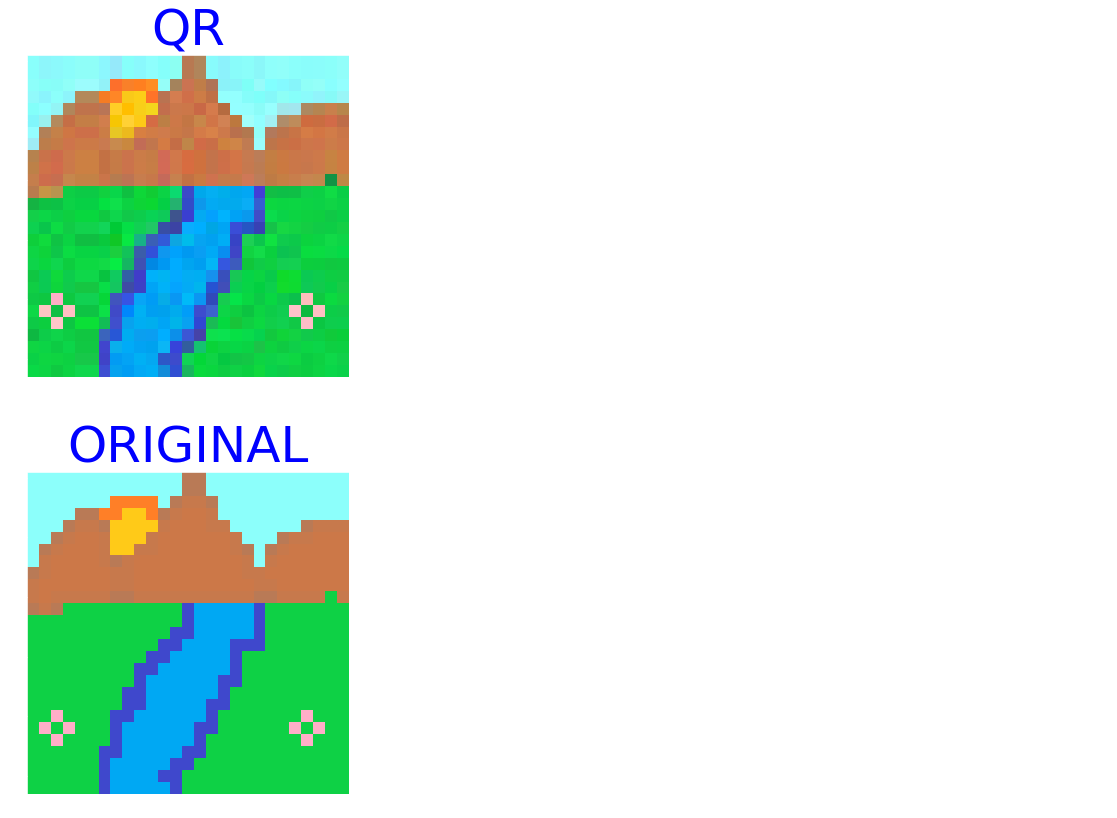

In [85]:
# Reconstructing low rank approximaiton of the original matrices
def reconstruct(u1, s1, vt1, u2, s2, vt2, u3, s3, vt3, rank):
    '''
        Function to reconstruct the final matrix
    '''
    reconst_r = mat_multiply(
        mat_multiply(mat_splice(u1, rows(u1), rank), mat_splice(s1, rank, rank)), 
        mat_splice(vt1, rank, cols(vt1)))
    reconst_g = mat_multiply(
        mat_multiply(mat_splice(u2, rows(u2), rank), mat_splice(s2, rank, rank)), 
        mat_splice(vt2, rank, cols(vt2)))
    reconst_b = mat_multiply(
        mat_multiply(mat_splice(u3, rows(u3), rank), mat_splice(s3, rank, rank)), 
        mat_splice(vt3, rank, cols(vt3)))

    final = list()
    data_type = 'float'

    # Combining R, G and B matrixes to form a 3-D matrix
    for i in range(rows(reconst_r)):
        row = list()
        for j in range(cols(reconst_r)):
            pixel = list()
            pixel.append((reconst_r[i][j]))
            pixel.append((reconst_g[i][j]))
            pixel.append((reconst_b[i][j]))
            if int(reconst_b[i][j]) > 1 and data_type != 'int':
                data_type = 'int'
            row.append(pixel)
        final.append(row)

    # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers
    if data_type == 'int':
        to_int(final)
    else:
        clip(final)

    return final

final_qr = reconstruct(u_1_qr, s_1_qr, vt_1_qr, 
                       u_2_qr, s_2_qr, vt_2_qr, 
                       u_3_qr, s_3_qr, vt_3_qr, 11)

fig, a = plt.subplots(2,2)
plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white', 
                'ytick.color':'white', 'figure.figsize':[18, 12]})

a[0][0].imshow(final_qr)
a[0][0].set_title('QR', color='b', fontsize= 50)

a[1][0].imshow(mat)
a[1][0].set_title('ORIGINAL', color='b', fontsize= 50)

fig.tight_layout(pad=3)
plt.show()

# *ANALYSIS*

In [86]:
def mean_square(mat_a, mat_b):
    '''
        Function which defines the mean square error between two matrices
    '''

    error = 0
    for i in range(rows(mat_a)):
        for j in range(cols(mat_a)):
            for k in range(3):
                error += math.pow((mat_a[i][j][k] - mat_b[i][j][k]), 2)

    error = error / (rows(mat_a) * cols(mat_a))
    return error

print("MEAN SQUARE ERRORS:")
print()
print(tabulate([["QR", mean_square(mat.tolist(), final_qr)]], 
                headers=['APPROACH', 'MEAN ERROR']))

MEAN SQUARE ERRORS:

APPROACH      MEAN ERROR
----------  ------------
QR             0.0034153
